## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [11]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [42]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [1]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [2]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [3]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSSSBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
23
+------------------+-------------------+--------------------+--------------------+---------+--------+--------+---------+-----------+--------------------+--------------------+--------------------+--------------------+------------------+-----------+---------+------+--------------------+------+
|           coeff_1|            coeff_2|             coeff_3|             coeff_4|elevation|   label|latitude|longitude|measurement|               res_1|               res_2|               res_3|               res_4|          res_mean|    station|total_var|undefs|              vector|  year|
+------------------+-------------------+--------------------+--------------------+---------+--------+--------+---------+-----------+--------------------+--------------------+--------------------+--------------------+------------------+-----------+---------+------+--------------------+------+
| 0.676954235772314| 470.58763560573317|-0.16808

In [20]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(5)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00045863| 34.0333|-116.5833|    780.9|  0.676954235772314|
|USC00046196| 33.5833|-116.4333|   1229.0| -785.3824822907103|
|USC00045502| 33.5714|-116.0767|    -54.9|0.47159197700603833|
|USC00045863| 34.0333|-116.5833|    780.9| 0.4240548021759546|
|USC00029287| 33.9792|-112.7403|    638.6| 0.4092385618277186|
+-----------+--------+---------+---------+-------------------+
only showing top 5 rows



In [19]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
print len(pdf)
pdf.head(12)

11


station  latitude  longitude  elevation  count(station)  avg(coeff_1)
9   USC00020060   33.9433  -113.1875      659.9               3      0.410511
8   USC00021282   33.8161  -111.9019      771.1               1      0.407942
5   USC00021365   33.7167  -112.0500      509.0               1      0.414160
6   USC00027453   33.7833  -113.6167      580.0               2    -43.230537
2   USC00028489   33.4333  -111.9333      351.1               1      0.439723
1   USC00029287   33.9792  -112.7403      638.6               2      0.408592
3   USC00042327   33.6514  -116.3764      365.8               1      0.408354
7   USC00043855   33.7044  -115.6289      417.6               2    -17.026399
4   USC00045502   33.5714  -116.0767      -54.9               1      0.471592
0   USC00045863   34.0333  -116.5833      780.9               7     -0.703133
10  USC00046196   33.5833  -116.4333     1229.0               2   -392.450580

In [6]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [9]:
min_lat,max_lat,min_long,max_long = box = (33.3369, 34.1158, -116.5833, -111.7432)


In [21]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count*100+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

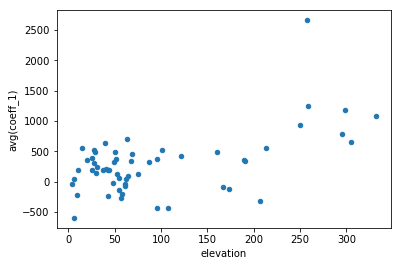

In [16]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [21]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']